/lustre/aoc/projects/hera/ajosaiti/SDR_RFI_monitoring_staging/20190409
Reading SDR_SpectrumPeak.20190409-180002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-160002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-200002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-000002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-100002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-040002.n238.None.ridz
Reading SDR_SpectrumPeak.20190409-080002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-020002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-220002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-060002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-120002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-140002.n240.None.ridz
Data span 2019-04-09 00:00:02 - 2019-04-09 23:59:32


/lustre/aoc/projects/hera/ajosaiti/SDR_RFI_monitoring/HERA_daily_RFI/xrfi_funcs.py:215: RuntimeWarning: divide by zero encountered in divide
  f = d_rs / sig


The filepath for the sp_handling_raw function used to make s. object is: /users/ajosaiti/anaconda/envs/py2.7env/lib/python2.7/site-packages/rids/features/sp_handling_raw.pyc


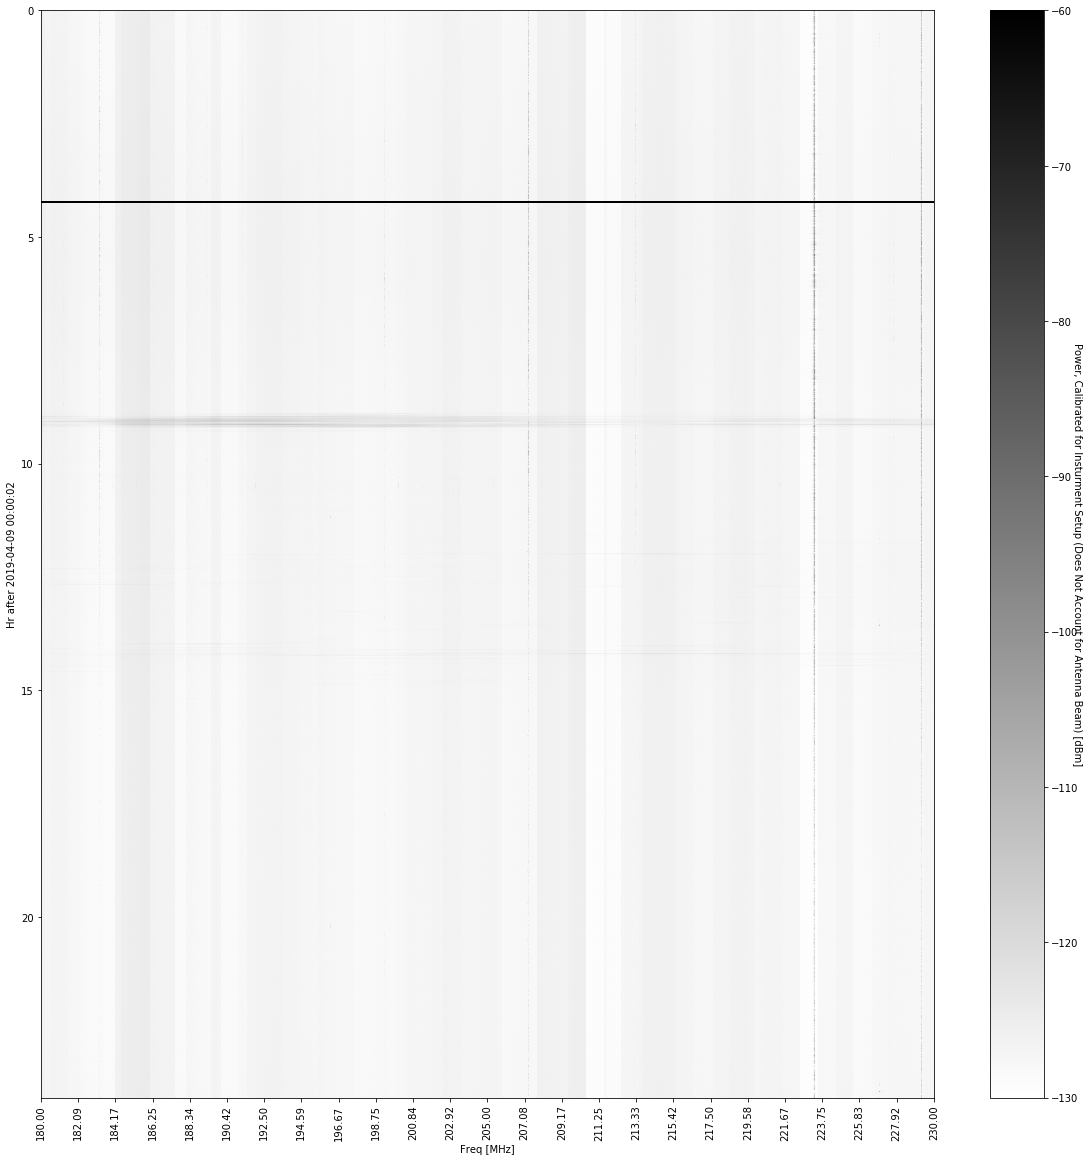

Reading SDR_SpectrumPeak.20190409-180002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-160002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-200002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-000002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-100002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-040002.n238.None.ridz
Reading SDR_SpectrumPeak.20190409-080002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-020002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-220002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-060002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-120002.n240.None.ridz
Reading SDR_SpectrumPeak.20190409-140002.n240.None.ridz
Data span 2019-04-09 00:00:02 - 2019-04-09 23:59:32
The filepath for the sp_handling_raw function used to make s. object is: /users/ajosaiti/anaconda/envs/py2.7env/lib/python2.7/site-packages/rids/features/sp_handling_raw.pyc
For XRFI algorithm: K = 8, shape of xrfi input (arr2D_pow): (18, 16390)


/lustre/aoc/projects/hera/ajosaiti/SDR_RFI_monitoring/HERA_daily_RFI/xrfi_funcs.py:215: RuntimeWarning: invalid value encountered in divide
  f = d_rs / sig
/lustre/aoc/projects/hera/ajosaiti/SDR_RFI_monitoring/HERA_daily_RFI/xrfi_funcs.py:86: RuntimeWarning: invalid value encountered in greater
  f1 = np.ma.array(d, mask=np.where(d > sig_init,1,0))
/lustre/aoc/projects/hera/ajosaiti/SDR_RFI_monitoring/HERA_daily_RFI/xrfi_funcs.py:98: RuntimeWarning: invalid value encountered in greater
  i = np.where(f1[xp,yp] > sig_adj)[0] # if sigma > 'sigl'


Shape of xrfi_mask: (18, 16390)
Peaks of total power per channel plot: (MHz)[ 51.5   52.17  52.18  52.19  52.2   52.22  56.49  56.5   57.24  57.26
  58.5   58.51  58.52  58.54  58.55  60.    60.12  60.14  60.15  60.38
  60.39  60.4   60.99  61.    61.01  61.03  61.26  61.27  61.69  61.7
  61.71  61.72  62.56  62.58  62.59  62.94  63.    63.02  63.03  63.63
  63.64  63.87  63.88  63.89  63.91  64.49  64.76  64.77  65.18  65.19
  65.2   65.21  65.63  65.64  65.65  66.51  66.52  66.93  66.94  66.96
  67.13  67.14  67.37  67.38  67.4   67.47  67.48  67.49  67.81  67.82
  68.67  68.68  68.69  68.7   68.71  68.73  69.12  69.13  69.14  69.15
  69.57  69.58  70.    70.01  70.02  70.41  70.42  70.43  70.45  70.46
  70.47  70.86  70.87  70.89  70.9   71.31  71.33  72.    72.01  72.18
  72.19  72.2   72.22  72.62  72.63  72.64  73.49  73.5   73.51  73.74
  73.75  73.77  73.92  73.94  73.95  73.96  74.36  74.38  74.39  74.63
  74.64  75.24  75.25  75.27  75.49  75.5   75.51  75.52  76.    76.01
  

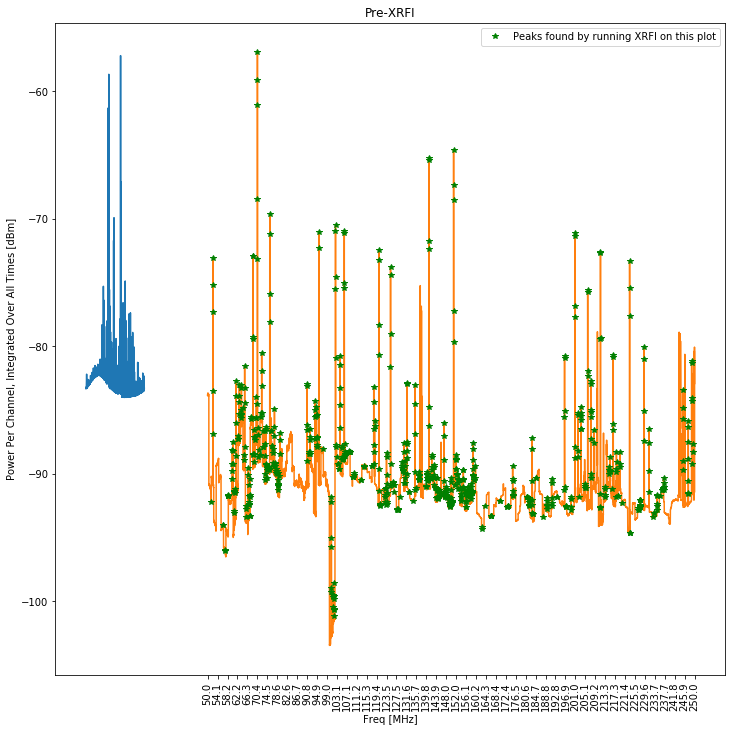

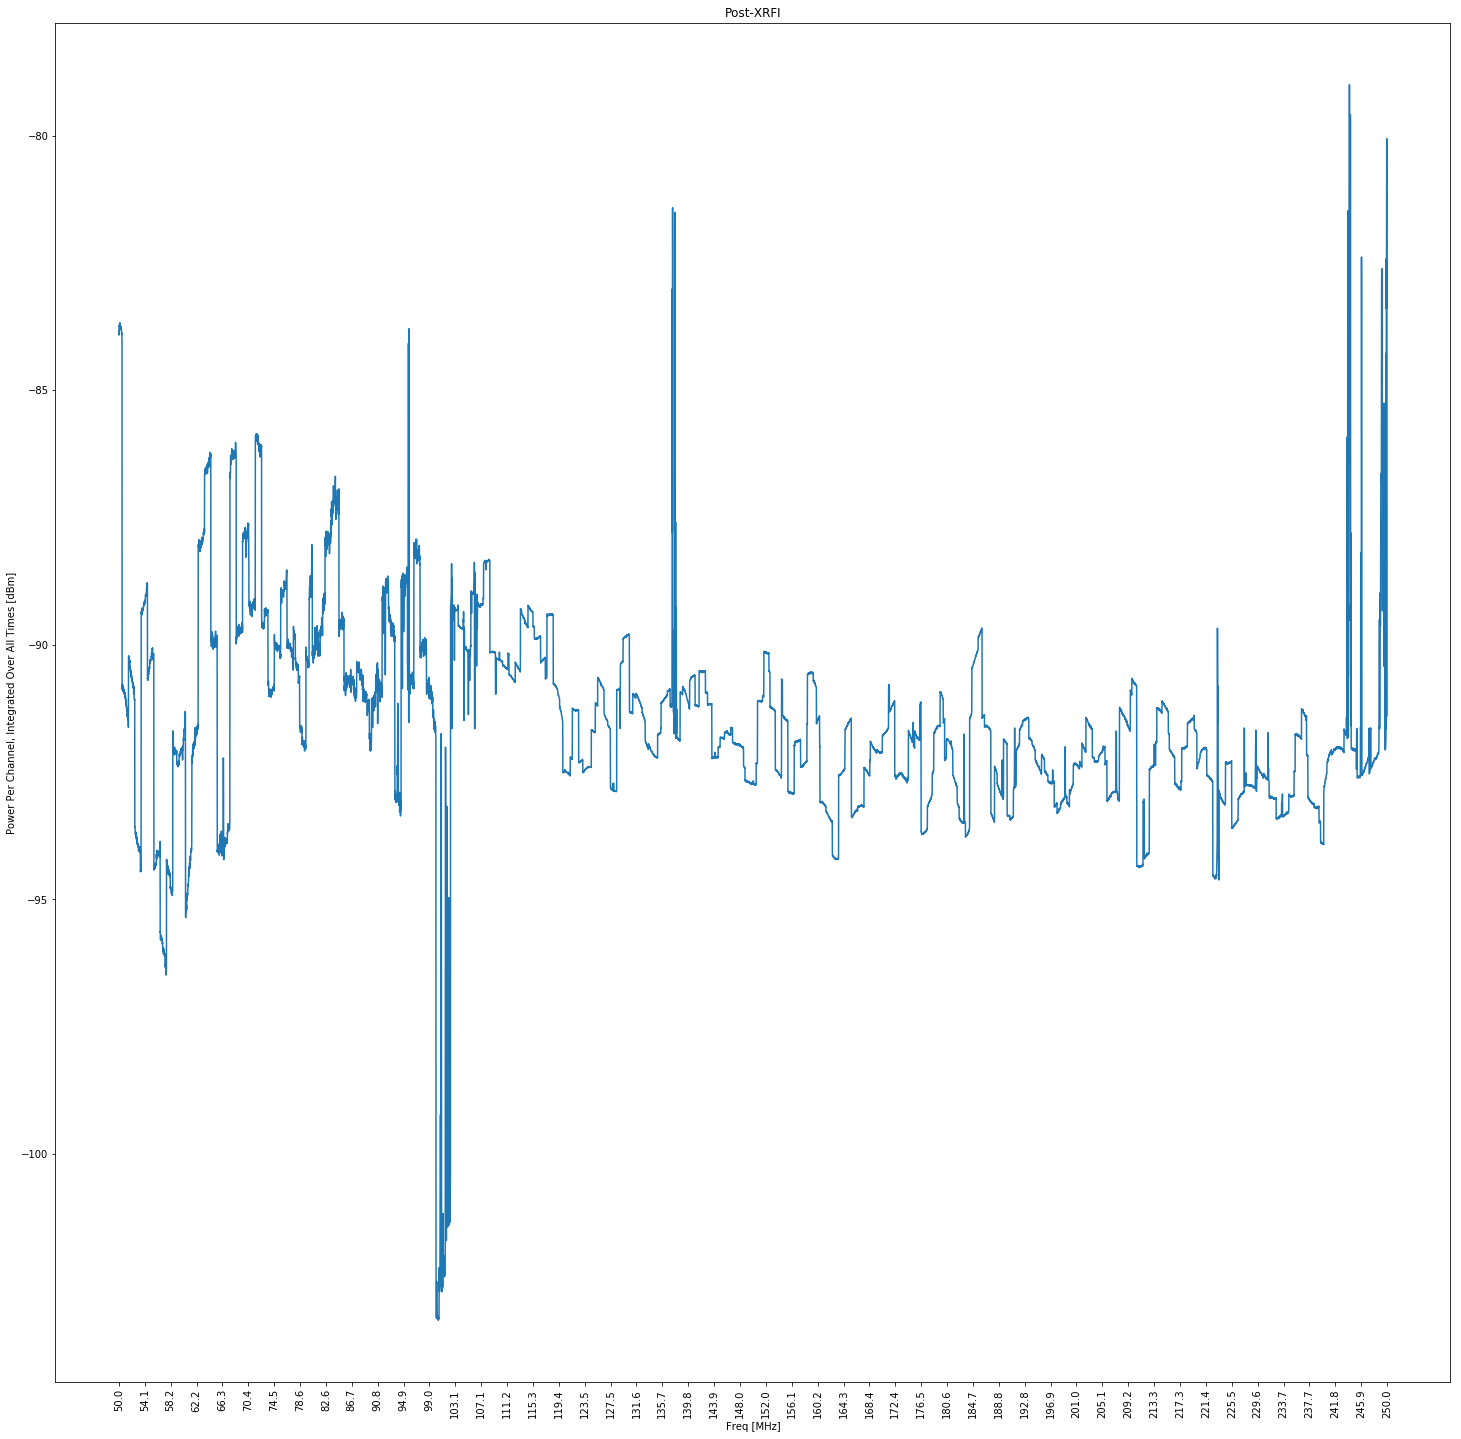

Percent of channels that, at any time(s) in the day, are flagged by XRFI: 97.8767541184%
For XRFI algorithm: K = 8, shape of xrfi input (arr2D_pow): (18, 16390)
Post-XRFI mask, frequencies which may still contain RFI: [ 56.79  56.8   56.82  56.83  56.84  56.85  56.86  56.88  56.89  56.9
  56.91  56.93  56.94  56.95  56.96  56.97  56.99  57.    57.01  57.02
  57.04  57.05  57.06  57.07  57.08  57.1   57.11  57.12  57.13  57.15
  57.16  57.17  57.18  57.19  57.21  57.22  57.23  57.24  57.26  57.27
  57.28  57.29  57.3   57.32  57.33  57.34  57.35  57.37  57.38  57.39
  57.4   57.41  57.43  57.44  57.45  57.46  57.48  57.49  57.51  68.4
  68.41  68.42  70.41  70.42  88.6   88.62  90.    90.01  90.02  90.84
  91.7   91.72  92.    92.01  92.02  93.69  96.61  96.62  96.93  96.94
  98.56  98.57  98.59  98.6   98.66  99.18  99.99 100.   100.01 100.03
 100.04 100.05 100.06 100.08 100.09 100.1  100.11 100.12 100.14 100.15
 100.16 100.17 100.19 100.2  100.21 100.22 100.23 100.25 100.26 100.27
 10

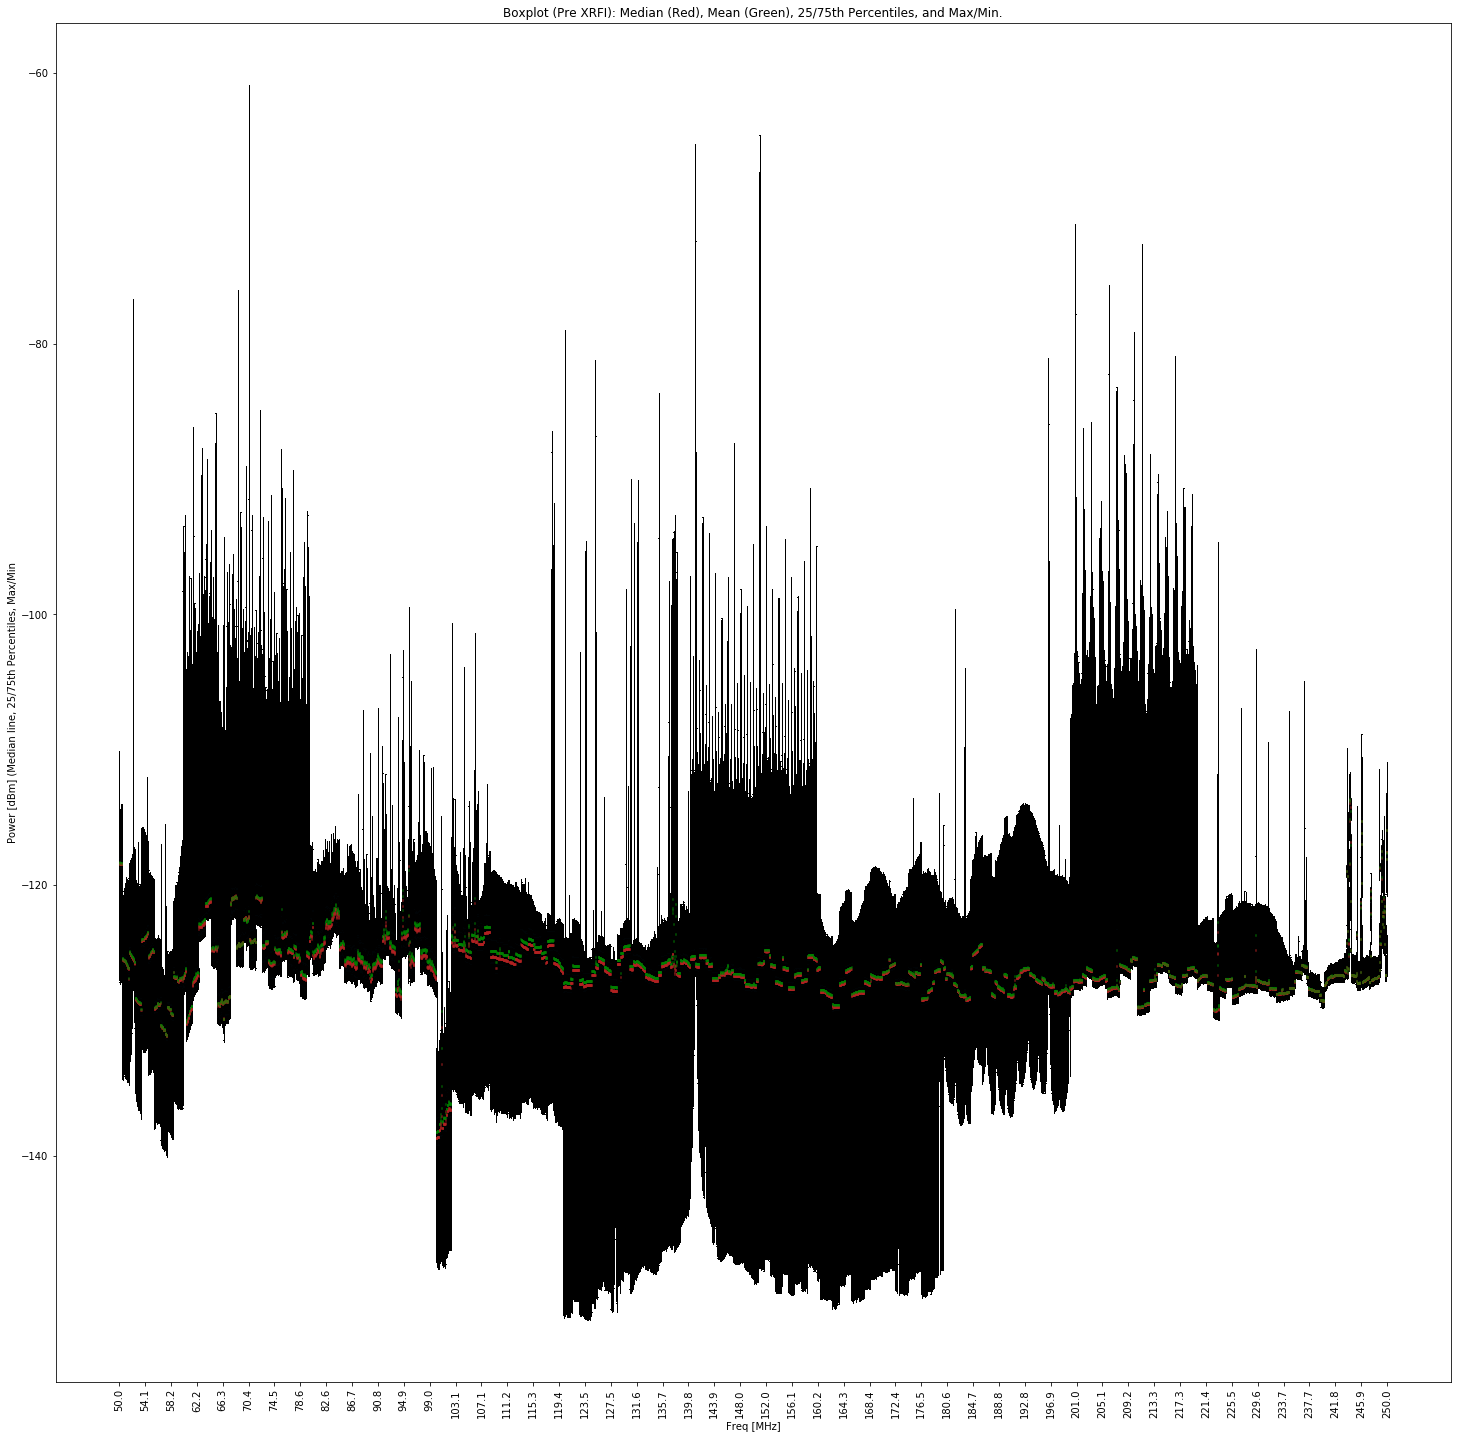

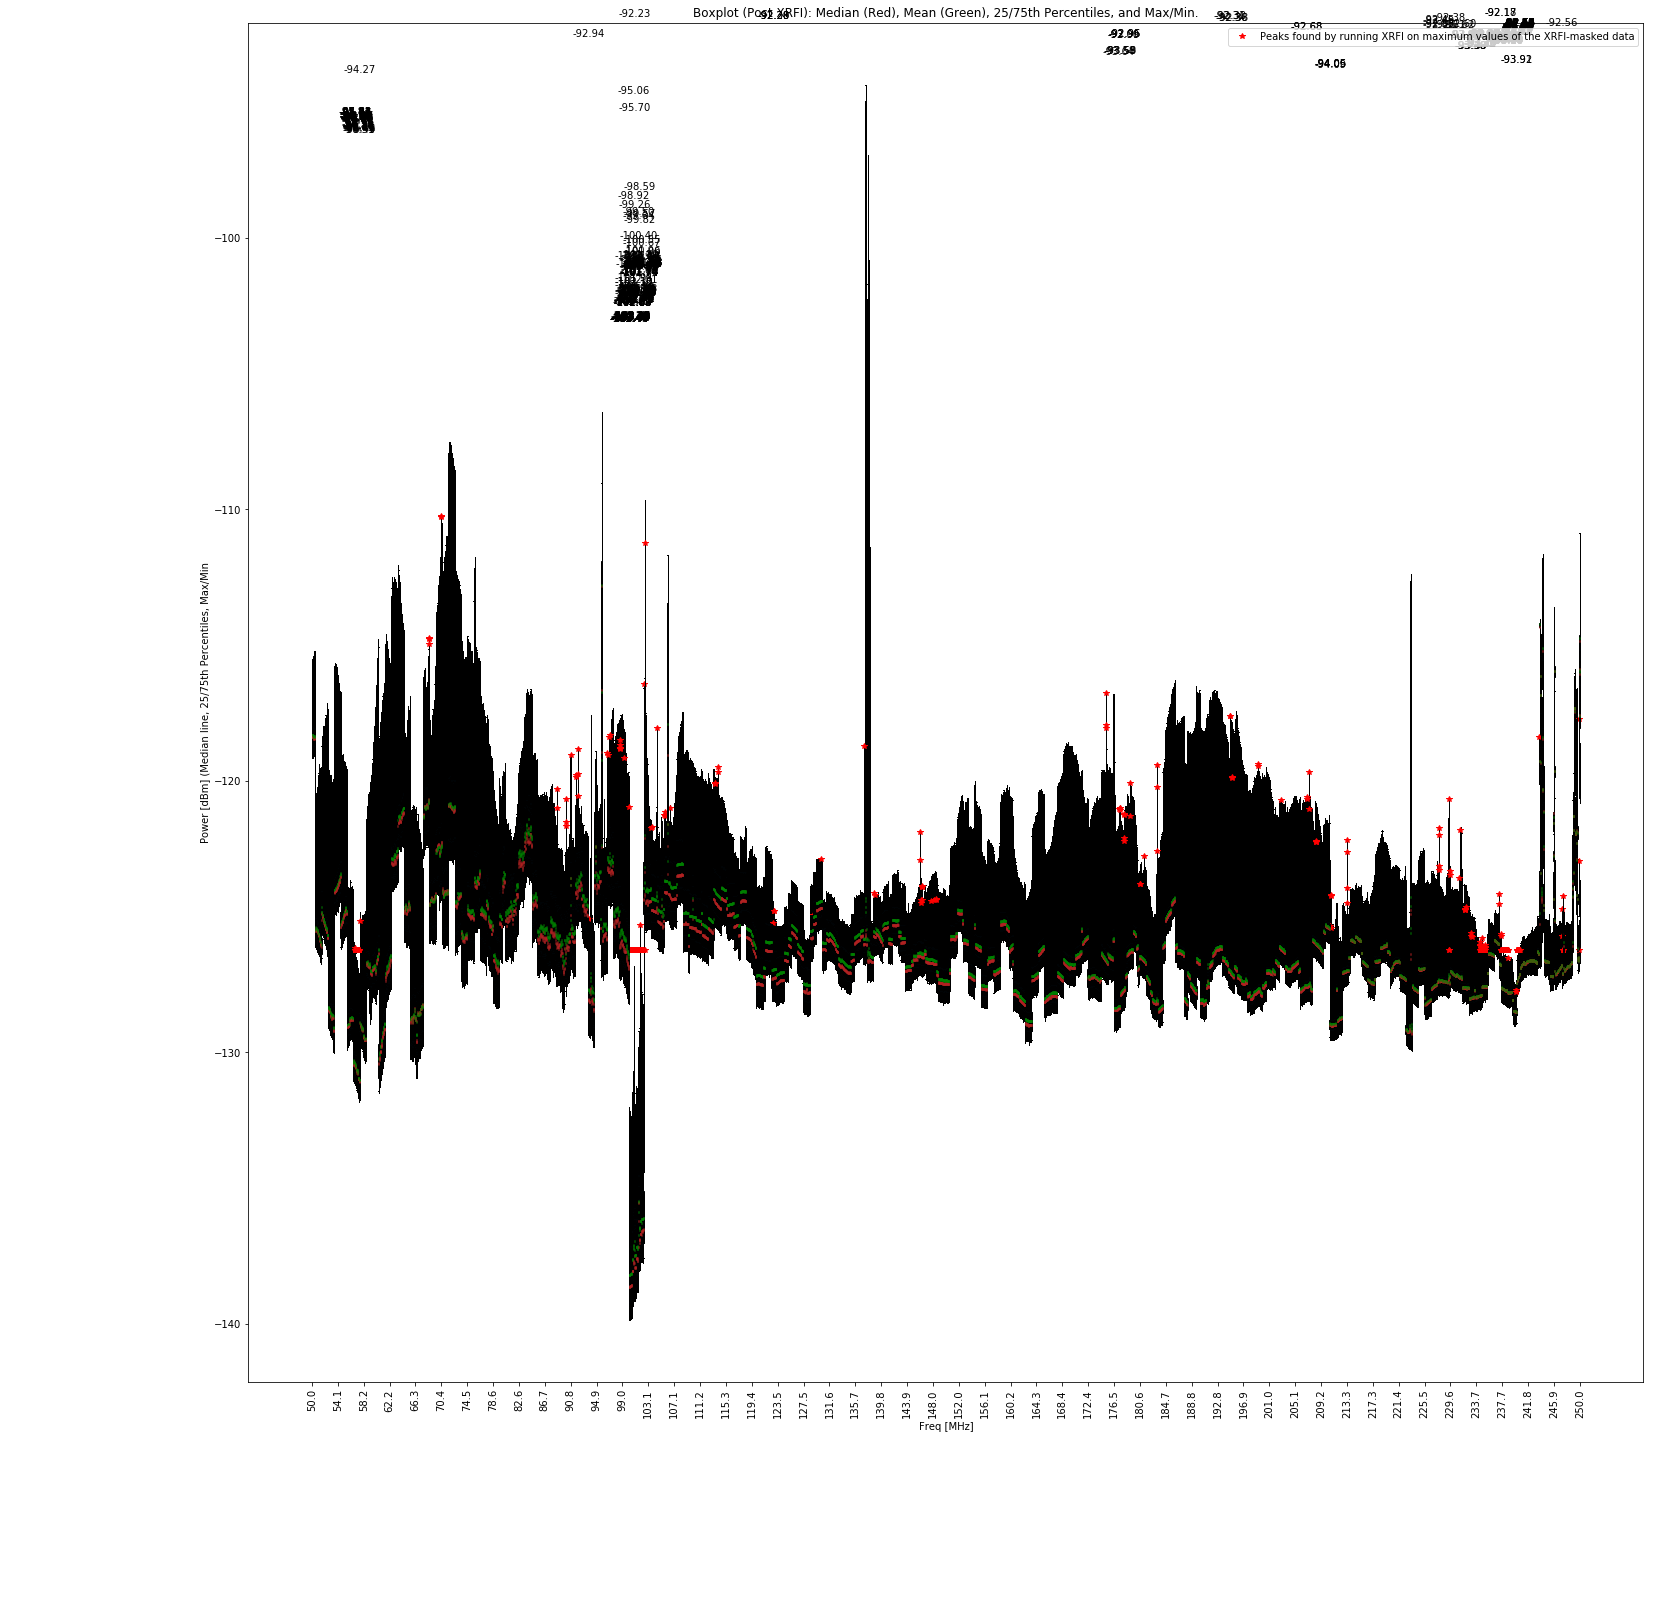

In [1]:
%matplotlib inline 
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import os
import json
import subprocess

OUT_DAY = 'arr_day.npy' #the output files containing integrated power and metadata for each sweep-spectrum on record
OUT_NIGHT = 'arr_night.npy'
SUNSET_TIMETABLE = np.genfromtxt('/lustre/aoc/projects/hera/ajosaiti/SDR_RFI_monitoring/HERA_daily_RFI/HERA_sunrise_sunset_annual.csv', dtype=str,delimiter=',') # Col 0: Month-day (mmdd), Col 1: Sunrise (hhmm), Col 2: Sunset (hhmm)
STR_DAY = os.environ['which_day']
DEBUG = bool(int(os.environ['DEBUG'])) #False

def file_flush():
	if DEBUG: print('flushing temporary and output files...')
	open(OUT_DAY, 'w').close()
	open(OUT_NIGHT, 'w').close()
	if DEBUG: print('done.')

def delta_hours_minutes(td):
    return td.seconds//3600, (td.seconds//60)%60

def recursive_key_search(dat, key): #https://stackoverflow.com/questions/9807634/find-all-occurrences-of-a-key-in-nested-python-dictionaries-and-lists
#sum_dbm_recursive_key_search(dat, key): #https://stackoverflow.com/questions/9807634/find-all-occurrences-of-a-key-in-nested-python-dictionaries-and-lists
    if key in dat:
        yield dat[key]
    for k in dat:
        if isinstance(dat[k], list):
            for i in dat[k]:
                for j in recursive_key_search(i):
                    yield j

def time_in_rids_fmt(datetime_time): # convert datetime.datetime.now() time into the RIDZ-requested format
	str_iso = datetime_time.isoformat(' ')
	str_time_rids = str( str_iso[0:4] + str_iso[5:7] + str_iso[8:10] + '-' + str_iso[11:13]+str_iso[14:16]+str_iso[17:19])
	return str_time_rids

def sum_array_of_dbm(arr):
	val_sum = 10.*np.log10(np.sum(np.power(10,np.array(arr)/10.)))
	return val_sum

def trunc_time(dt):
    dt_trunc = datetime.date(dt.day, dt.hour, dt.minute, dt.second)
    return dt_trunc

def calc_wf_and_integrated_power(sunrise, sunset):
    ## check these fileid aren't in the processed_sessid.txt file
    processed_file_dir = os.path.dirname(os.environ['DATA_PATH'])
    processed_fileid = np.loadtxt(os.path.join(processed_file_dir, 'processed_fileid.txt'), dtype=np.int)
    if DEBUG: 
        print('NOTE: Since in DEBUG mode, Will reprocess files if instructed.')
        
    # filter out sessions already processed
    unprocessed_files = []
    pathname = []
    for diritem in os.listdir(os.environ['staging_dir']):
        if DEBUG: 
            print('in ipynb, staging_dir is: '+str(os.environ['staging_dir']))
        if os.path.isdir(diritem) or str(diritem).isdigit():
            pathname = str(str(os.environ['staging_dir'])+'/'+str(diritem)+'/')
            print('  '+str(diritem)+' considered to be a dir.')
            for dir_file in os.listdir(pathname):
                name=str(dir_file)#file["name"])
                if DEBUG: print('   In dir, pathname: '+str(pathname)+', dirfile: '+str(name))
                fileid = int(name[int(name.find('.')+1):name.find('-')])
                if (fileid not in processed_fileid) or DEBUG:
                    unprocessed_files.append(name)
                    
        else:
            pathname = str(os.environ['staging_dir']+'/')
            name=str(diritem)#file["name"])
            if DEBUG: 
                print('  '+str(name)+' is thought to be a file, not a directory.')
                print('    diritem is a file, name: '+str(name))
            fileid = int(name[int(name.find('.')+1):name.find('-')])
            if (fileid not in processed_fileid) or DEBUG:
                unprocessed_files.append(name)

    if DEBUG: 
        print('List of unprocessed files (or all files if DEBUG): '+str(unprocessed_files))
        print('Ready to analyze files in pathname "'+str(pathname)+'".')
        print('launching subprocess...')
    %cd {pathname}
    str_args = str( str( ','.join([str(s) for s in os.listdir(pathname) if s.endswith('.ridz') and STR_DAY in s and os.stat(s).st_size !=0])))
    if DEBUG: print('str_args: '+str(str_args))
    %run /users/ajosaiti/anaconda/envs/py2.7env/rids/scripts/sp_rawview.py --wf val -f '180.,230.' {str_args}
    #%run /users/ajosaiti/anaconda/envs/py2.7env/rids/scripts/sp_rawview.py --statsplot val -f '180.,230.' {str_args}
    #%run /users/ajosaiti/anaconda/envs/py2.7env/rids/scripts/sp_rawview.py --totalpower val -f '50.,250.' {str_args}
    %run /users/ajosaiti/anaconda/envs/py2.7env/rids/scripts/sp_rawview.py --ptot_and_stats val -f '50.,250.' {str_args}
    if DEBUG: print('    ...subprocess complete.')

    return pathname 

#For the day in question, figure out when sunset and sunrise were. 
col_date,col_key = np.where(SUNSET_TIMETABLE == STR_DAY[4:]) #find mmdd, but it could also be a time
sunrise = datetime.datetime.strptime( str(str(STR_DAY[:4])+str(STR_DAY[4:])+'-'+str(SUNSET_TIMETABLE[int(col_date[col_key==0])][1])) ,'%Y%m%d-%H%M')
sunset = datetime.datetime.strptime( str(str(STR_DAY[:4])+str(STR_DAY[4:])+'-'+str(SUNSET_TIMETABLE[int(col_date[col_key==0])][2])) ,'%Y%m%d-%H%M')
delta_hour, delta_minute = delta_hours_minutes((sunset-sunrise))
if DEBUG: 
    print( 'Sunrise and sunset objects have type '+str(str(type(sunrise))+', '+str(type(sunset))) )
    print( 'Sunrise: '+str(sunrise)+', Sunset: '+str(sunset))
    #print( 'Sunrise hour: '+str(sunrise.hour))
#Arrays containing data from each sweep measurement, sorted by whether the data occured in the daytime or nighttime.
arr_day=[] # [datetime.datetime object], [float(integrated power)]
arr_night=[]


file_flush() # Make sure output files aren't reused with old data in them.
pathname = calc_wf_and_integrated_power(sunrise, sunset)

#create pathname environment variable so I can add librarian events in run_notebook.sh. This pathname may be different than the staging_dir var.
os.environ['staging_pathname']=pathname
#%env staging_pathname=pathname
